In [204]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import utm

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, mean_squared_error, classification_report

import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation, concatenate
from keras.callbacks import History
from keras.models import Model

# The values have around 15 decimals, so for more clarity in reading we're increasing the number of displayed values
pd.set_option('display.float_format', '{:.15f}'.format)

# 1. Importing the data

In [2]:
sensor_and_loc_file = '../data/Processed/full_sensor_data_and_location.csv'

In [92]:
df_sensor_and_loc = pd.read_csv(sensor_and_loc_file, index_col=0)
df_sensor_and_loc

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:61,0.412078860000000,0.443542480000000,9.409470000000001,0.032653810000000,0.321075440000000,-0.377655030000000,52.368546000000002,-50.530624000000003,-260.906787500000007,9.428927012090160,0.496768589146909,270.865587926351282,44.434937499999990,26.047601578717067
12:15:51:62,0.378555300000000,0.465087900000000,9.435805999999999,0.018798828000000,0.324279800000000,-0.366989140000000,52.387238000000004,-50.511932000000002,-260.963054999999997,9.454842449217251,0.490093678290338,270.919923600955030,44.434937499999990,26.047601657434136
12:15:51:63,0.468096920000000,0.524942020000000,9.467889200000000,0.034353637600000,0.316397106000000,-0.364859012000000,52.405929999999998,-50.493240000000000,-261.019322499999987,9.496275903028236,0.485338498843436,270.974259275558779,44.434937499999982,26.047601736151204
12:15:51:64,0.557638540000000,0.584796140000000,9.499972400000001,0.049908447200000,0.308514412000000,-0.362728884000000,52.424621999999999,-50.474547999999999,-261.075590000000034,9.537709356839221,0.480583319396533,271.028594950162585,44.434937499999982,26.047601814868269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19:09:27:16,1.302719100000000,0.520156860000000,7.142166000000000,-0.118621826000000,-0.505569460000000,0.092132570000000,22.650145999999999,-15.150451500000001,-262.875364999999988,7.278610814164050,0.527408785424618,264.286459212824525,44.434937499964583,26.047601919741037
19:09:27:17,2.049713100000000,0.280731200000000,8.202788999999999,-0.301849370000000,-0.332992550000000,0.140075680000000,23.100280000000001,-16.200256000000000,-262.800599999999974,8.459662001373697,0.470763503951147,264.310852200404213,44.434937499964576,26.047601814784940
19:09:27:18,2.140686000000000,0.043701172000000,9.170044000000001,-0.590530400000000,0.304031370000000,0.046325684000000,23.100280000000001,-13.949585000000001,-261.749270000000024,9.416695455676912,0.665813259304968,263.136645496752351,44.434937499964576,26.047601709828850
19:09:27:19,1.896484400000000,-0.226837160000000,9.799728000000000,-0.686401370000000,0.651306150000000,-0.067657470000000,24.050394333333333,-13.749694999999999,-262.549340000000029,9.984126253738191,0.948643281224560,264.009983987171552,44.434937499964569,26.047601604872760


## 1.1. Creating x and y

In [93]:
# df_sensor_and_loc['x'] = np.nan
# df_sensor_and_loc['y'] = np.nan
# for i in range(len(df_sensor_and_loc)):
#     lat = df_sensor_and_loc['lat'].iloc[i]
#     long = df_sensor_and_loc['long'].iloc[i]
#     df_sensor_and_loc['x'].iloc[i], df_sensor_and_loc['y'].iloc[i], zone, ut = utm.from_latlon(df_sensor_and_loc['lat'].iloc[i], df_sensor_and_loc['long'].iloc[i])
# df_sensor_and_loc

In [94]:
# plt.scatter(x=df_sensor_and_loc['x'], y=df_sensor_and_loc['y'])

In [225]:
data = df_sensor_and_loc.copy(deep=True)[::10]
# data = data.iloc[:len(data)//2][::10]
# data.reset_index(inplace=True)
# data.drop(['index'], axis=1, inplace=True)
print(data.shape)
data.head()

(6371, 14)


,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:70,0.764022800000000,0.639862060000000,8.693603500000000,-0.093048096000000,0.537323000000000,-0.366989140000000,53.250121999999998,-49.650573999999999,-260.699459999999988,8.750536904096773,0.657308894946786,270.675014428439624,44.434937499999954,26.047602287170680
12:15:51:80,0.558120700000000,0.364532470000000,10.486862000000000,-0.098373410000000,0.309356700000000,-0.109207150000000,55.200195000000001,-48.599243000000001,-260.249329999999986,10.508028228192805,0.342498317136071,270.441604997566856,44.434937499999911,26.047603074341360
12:15:51:90,0.780777000000000,1.101944000000000,9.859589000000000,-0.254974370000000,-0.464019780000000,-0.092163086000000,56.399535999999998,-50.100707999999997,-261.000060000000019,9.951652553811654,0.537420059180143,271.683676217619222,44.434937499999869,26.047603861512041
12:15:52:00,0.639526370000000,1.717254600000000,9.689590000000001,-0.199584960000000,-0.171066280000000,-0.063400270000000,55.199431500000003,-49.124908499999997,-260.475160000000017,9.861344315418997,0.270402334766756,270.757870006502344,44.434937499999819,26.047604648682714


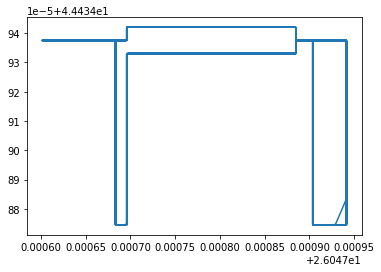

In [226]:
plt.plot(data['long'], data['lat'])

In [227]:
# plt.plot(data['x'], data['y'])

# 2. Creating the LSTM model

## 2.1. Scaling the data

In [242]:
backcandles=100

sc_attributes = MinMaxScaler(feature_range=(-1, 1))
attributes_scaled = sc_attributes.fit_transform(data.iloc[:, :-5])
sc_targets = MinMaxScaler(feature_range=(0, 1))
targets_scaled = sc_targets.fit_transform(data.iloc[backcandles:, [-2, -1]])
# y_test_1 = data.iloc[:, [-2, -1]]
# print(y_test_1)
# y_test_sc = sc.fit_transform(data.iloc[:, [-2, -1]])
# print(data_scaled)

In [243]:
print(attributes_scaled.shape[0], attributes_scaled.shape[1])

6371 9


## 2.2. Principal Component Analysis (PCA)

In [244]:
# pca = PCA(n_components=3)

In [245]:
# pca.fit_transform(attributes_scaled)

## 2.2. Reshaping the data in order to feed it to the model

In [246]:
# The following cell does this:

# []
# i = 0
# X = [[]]
# for j in range(30, 8611)
#     J = 30
#     X[0].append(data_scaled[30-30=0:30, 0]) --> append and array
#     J = 31
#     X[0].append(31-30=1:31, 0)
#     
# i = 1
# X = [
#       [  <-- 12 of those
#        [5.5811, 5.4786, .., 5.1232  <--- 30 (backcandles) of those], [], ..., [] <--- 8581 of those
#       ],
#      [
#        [5.5811, 5.4786, .., 5.1232], [], ..., []
#      ]
#    ]   ---> 
# for j in range(30, 8611)
#     X[0].append(data_scaled[30-30:30, 0])

In [247]:
X = []
backcandles=backcandles # number of last values to look into

for i in range(9): #number of attributes columns
    X.append([])
    for j in range(backcandles, attributes_scaled.shape[0]):
        X[i].append(attributes_scaled[j-backcandles:j, i])
        
# move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

# We need shape (8581, 30, 12) = (rows, val of past attributes, columns) for LSTM training
X.shape

(6271, 100, 9)

In [248]:
# Transform X and the targets (lat and long columns) into arrays so the axis can be moved and the data 
# to be used in the LSTM model
X, y = np.array(X), np.array(targets_scaled)

# Move the axis for yi, so instead of (8581, 2) we'll have (8581, 1, 2)
# I HAVE MODIFIED THIS:
# y = np.reshape(yi,(len(yi), 1, 2))
# y = np.reshape(yi,(len(yi), 2))

print('X Shape: ',X.shape)
print('y shape: ', y.shape)
targets_scaled

X Shape:  (6271, 100, 9)
y shape:  (6271, 2)


array([[0.89523834, 0.24074098],
       [0.88888913, 0.24074098],
       [0.88253993, 0.24074098],
       ...,
       [0.93333312, 0.00802469],
       [0.93333312, 0.00493827],
       [0.93333312, 0.00185185]])

## 2.3. Split the data into train, test and validation sets

In [249]:
splitlimit_test = int(len(X) * 0.7)
splitlimit_val = int(len(X) * 0.9)

print(splitlimit_test, splitlimit_val)
X_train, X_test, X_val = X[:splitlimit_test], X[splitlimit_test:splitlimit_val], X[splitlimit_val:]
y_train, y_test, y_val = y[:splitlimit_test], y[splitlimit_test:splitlimit_val], y[splitlimit_val:]
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

4389 5643
(4389, 100, 9)
(1254, 100, 9)
(628, 100, 9)
(4389, 2)
(1254, 2)
(628, 2)


## 2.4. Creating the LSTM  model

### 2.4.1. Create function to plot the training

In [250]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

### 2.4.2. Parametrizing the model

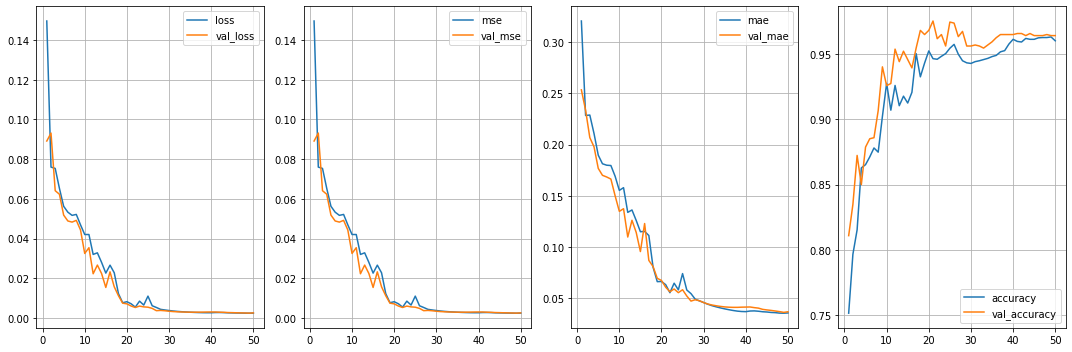

44/44 [==============================] - 8s 193ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0357 - accuracy: 0.9601 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0369 - val_accuracy: 0.9641


In [251]:
attributes_cols = 9
batch_size=100
epochs=50

lstm_input = Input(shape=(backcandles, attributes_cols), name='lstm_input')
inputs = LSTM(128, name='first_layer', return_sequences=False)(lstm_input)
# inputs = LSTM(64, activation='relu', name='second_layer', return_sequences=False)(inputs)
inputs = Dense(2, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()

model.compile(optimizer=adam, loss='mse', metrics=['mse', 'mae', 'accuracy'])
model.fit(x=X_train, 
          y=y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          shuffle=False, 
          validation_data=(X_test, y_test), 
          callbacks=[PlotLearning()])

# model = Sequential()
# model.add(LSTM(128, activation='relu', name='first_layer', return_sequences=True))
# model.add(LSTM(128, activation='relu', name='second_layer', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(2, name='dense_layer'))
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=epochs)

In [252]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])
len(y_pred), len(y_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

40/40 [==============================] - 1s 23ms/step
[0.91967946 0.1985276 ] [0.93333317 0.19759258]
[0.91813886 0.19804165] [0.93333317 0.19666666]
[0.917032   0.19864844] [0.93333317 0.19574073]
[0.9169028  0.19833069] [0.93333317 0.19481481]
[0.91630596 0.19966021] [0.93333317 0.19388888]
[0.91837716 0.19795361] [0.93333317 0.19296295]
[0.91585493 0.19952597] [0.93333317 0.19203703]
[0.9126575  0.20005573] [0.93333317 0.1911111 ]
[0.91301036 0.20245689] [0.93333317 0.19018518]
[0.91640604 0.20234412] [0.93333317 0.18925925]
Mean Squared Error (MSE): 0.0025286545084045146
R-squared: 0.9713027599271451


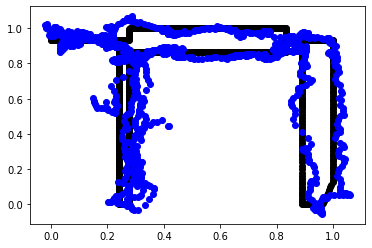

In [253]:
plt.scatter(y_test[:, 1], y_test[:, 0], color='black', label='Test')
plt.scatter(y_pred[:, 1], y_pred[:, 0], color='blue', label='Pred')
# y_test, y_pred

Mean Squared Error (MSE): 9.653118501559906e-11
R-squared: 0.9664048778145083
[[44.4349375  26.04766869]
 [44.4349375  26.04766838]
 [44.4349375  26.04766806]
 ...
 [44.434933   26.04775484]
 [44.434933   26.04775642]
 [44.434933   26.04775799]] [[44.434937 26.047668]
 [44.434937 26.047668]
 [44.434937 26.047668]
 ...
 [44.43493  26.04774 ]
 [44.43493  26.047737]
 [44.43493  26.047735]]


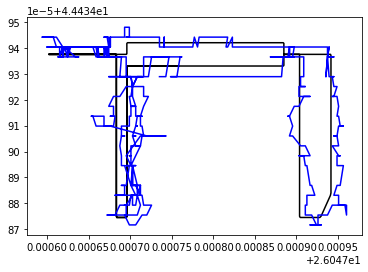

In [254]:
y_test_normalized = sc_targets.inverse_transform(y_test)
y_pred_normalized = sc_targets.inverse_transform(y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_normalized, y_pred_normalized)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared
r2 = r2_score(y_test_normalized, y_pred_normalized)
print("R-squared:", r2)

plt.plot(y_test_normalized[:, 1], y_test_normalized[:, 0], color='black', label='Test')
plt.plot(y_pred_normalized[:, 1], y_pred_normalized[:, 0], color='blue', label='Pred')
print(y_test_normalized, y_pred_normalized)

In [255]:
model.evaluate(X_test, y_test)

40/40 [==============================] - 1s 23ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0369 - accuracy: 0.9641


[0.0025286544114351273,
 0.0025286544114351273,
 0.03687033802270889,
 0.9641148447990417]